<a href="https://colab.research.google.com/github/letrongminh/Torch4GANs/blob/main/Transformer_05_Darts_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [2]:
!pip install darts

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset, TemperatureDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [34]:
from darts.models import TransformerModel, ExponentialSmoothing
from darts.datasets import SunspotsDataset
from sklearn.model_selection import train_test_split
import torch

# Prepare data

In [5]:
df = pd.read_csv('/content/mini_co2.csv')
#df_train, df_test = train_test_split(df, test_size=0.15)
#df['timestamp'] = df[['timestamp']].apply(lambda x: x[0], axis=1).astype(str)
#print(df.ts)
# df = df.astype(np.float32)
print(df.shape)

(2768, 2)


In [6]:
df['ts'] = df['ts'].astype('datetime64[ns]')
#df_train['ts'] = df_train['ts'].astype('datetime64[ns]')
#df_test['ts'] = df_test['ts'].astype('datetime64[ns]')

In [7]:
# if the source is a dataframe: create a time series object from a dataframe's column
# co2, temperature, humidity, pm25, pm10
ts = TimeSeries.from_series(df["co2"])
#ts_train = TimeSeries.from_series(df_train["pm25"])
#ts_test = TimeSeries.from_series(df_test["pm25"])

#ts_train, ts_test = ts.split_before(0.92)
ts_train, ts_test = ts[:-240], ts[-240:]
print("ts: ", ts, "ts_train: ", ts_train, "ts_test: ", ts_test)

ts:  <TimeSeries (DataArray) (time: 2768, component: 1, sample: 1)>
array([[[ 708.]],

       [[ 694.]],

       [[ 693.]],

       ...,

       [[1369.]],

       [[1360.]],

       [[1355.]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2761 2762 2763 2764 2765 2766 2767
  * component  (component) object 'co2'
Dimensions without coordinates: sample ts_train:  <TimeSeries (DataArray) (time: 2528, component: 1, sample: 1)>
array([[[ 708.]],

       [[ 694.]],

       [[ 693.]],

       ...,

       [[ 988.]],

       [[1004.]],

       [[ 985.]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2521 2522 2523 2524 2525 2526 2527
  * component  (component) object 'co2'
Dimensions without coordinates: sample ts_test:  <TimeSeries (DataArray) (time: 240, component: 1, sample: 1)>
array([[[1040.]],

       [[1067.]],

       [[1081.]],

       [[1180.]],

       [[1195.]],

       [[1228.]],

       [[1225.]],

       [[1242.]],

       [[1221.]],

       [[1228.]

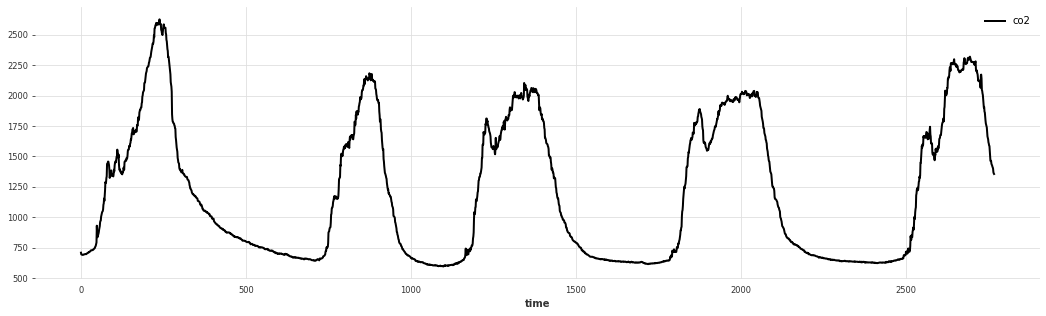

In [8]:
# plot the observations
plt.figure(figsize=(18, 5))
ts.plot()

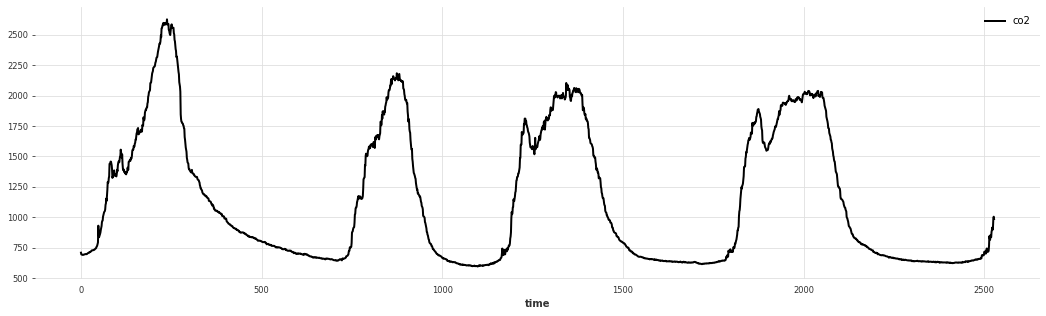

In [9]:
plt.figure(figsize=(18, 5))
ts_train.plot()

In [10]:
scaler = Scaler()

train_scaled = scaler.fit_transform(ts_train)
val_scaled = scaler.transform(ts_test)
ts_scaled = scaler.transform(ts)

In [11]:
print(len(train_scaled), len(val_scaled), len(ts_scaled))
print("the CO2 dataset has {} data points".format(len(ts)))

2528 240 2768
the CO2 dataset has 2768 data points


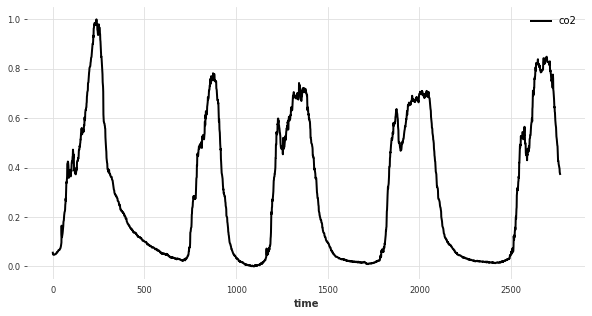

In [12]:
plt.figure(figsize=(10, 5))
ts_scaled.plot()

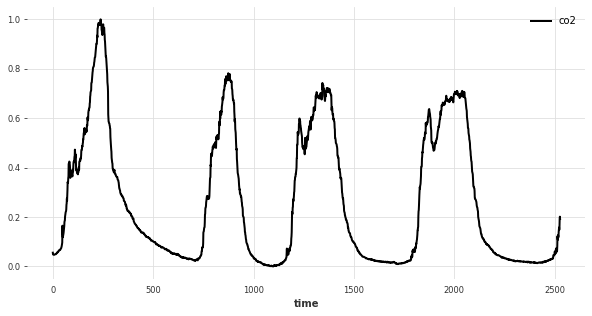

In [13]:
plt.figure(figsize=(10, 5))
train_scaled.plot()

# Model Transformer

In [ ]:
my_model_ = TransformerModel(
    batch_size=16,
    input_chunk_length=180,
    output_chunk_length=30,
    n_epochs=100,
    model_name="transformer_training",
    nr_epochs_val_period=5,
    d_model=16,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    random_state=42,
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    force_reset=True,
    add_encoders={
    'datetime_attribute': {'future': ['hour', 'day', 'month']},
    'position': {'past': ['absolute'], 'future': ['relative']},
    'transformer': Scaler()
}
)

In [ ]:
my_model_.fit(series=train_scaled, val_series=val_scaled, verbose=True)

  1%|          | 1/100 [00:04<07:05,  4.29s/it]

  6%|▌         | 6/100 [00:24<06:25,  4.10s/it]

 11%|█         | 11/100 [00:45<06:05,  4.10s/it]

 16%|█▌        | 16/100 [01:05<05:42,  4.08s/it]

 21%|██        | 21/100 [01:26<05:23,  4.09s/it]

 26%|██▌       | 26/100 [01:46<05:03,  4.10s/it]

 31%|███       | 31/100 [02:06<04:41,  4.08s/it]

 36%|███▌      | 36/100 [02:27<04:20,  4.07s/it]

 41%|████      | 41/100 [02:47<04:00,  4.07s/it]

 46%|████▌     | 46/100 [03:07<03:39,  4.07s/it]

 51%|█████     | 51/100 [03:28<03:19,  4.07s/it]

 56%|█████▌    | 56/100 [03:48<02:58,  4.06s/it]

 61%|██████    | 61/100 [04:08<02:38,  4.06s/it]

 66%|██████▌   | 66/100 [04:29<02:18,  4.07s/it]

 71%|███████   | 71/100 [04:49<01:58,  4.07s/it]

 76%|███████▌  | 76/100 [05:09<01:37,  4.07s/it]

 81%|████████  | 81/100 [05:30<01:17,  4.07s/it]

 86%|████████▌ | 86/100 [05:50<00:56,  4.07s/it]

 91%|█████████ | 91/100 [06:10<00:36,  4.06s/it]

 96%|█████████▌| 96/100 [06:31<00:16,  4.07s/it]

100%|██████████| 100/100 [06:47<00:00,  4.07s/it]


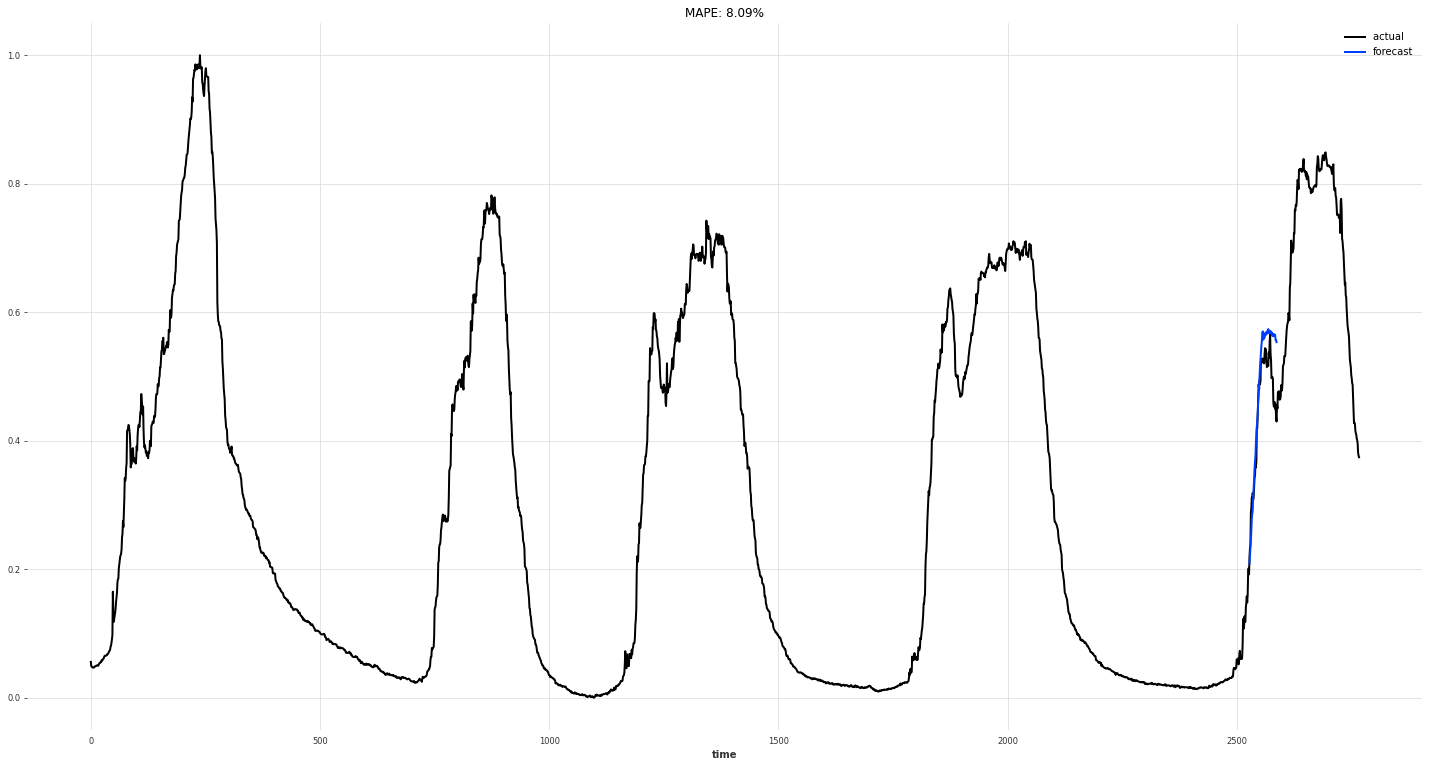

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series.plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('1.png')


eval_model(my_model_, 60, ts_scaled, val_scaled)

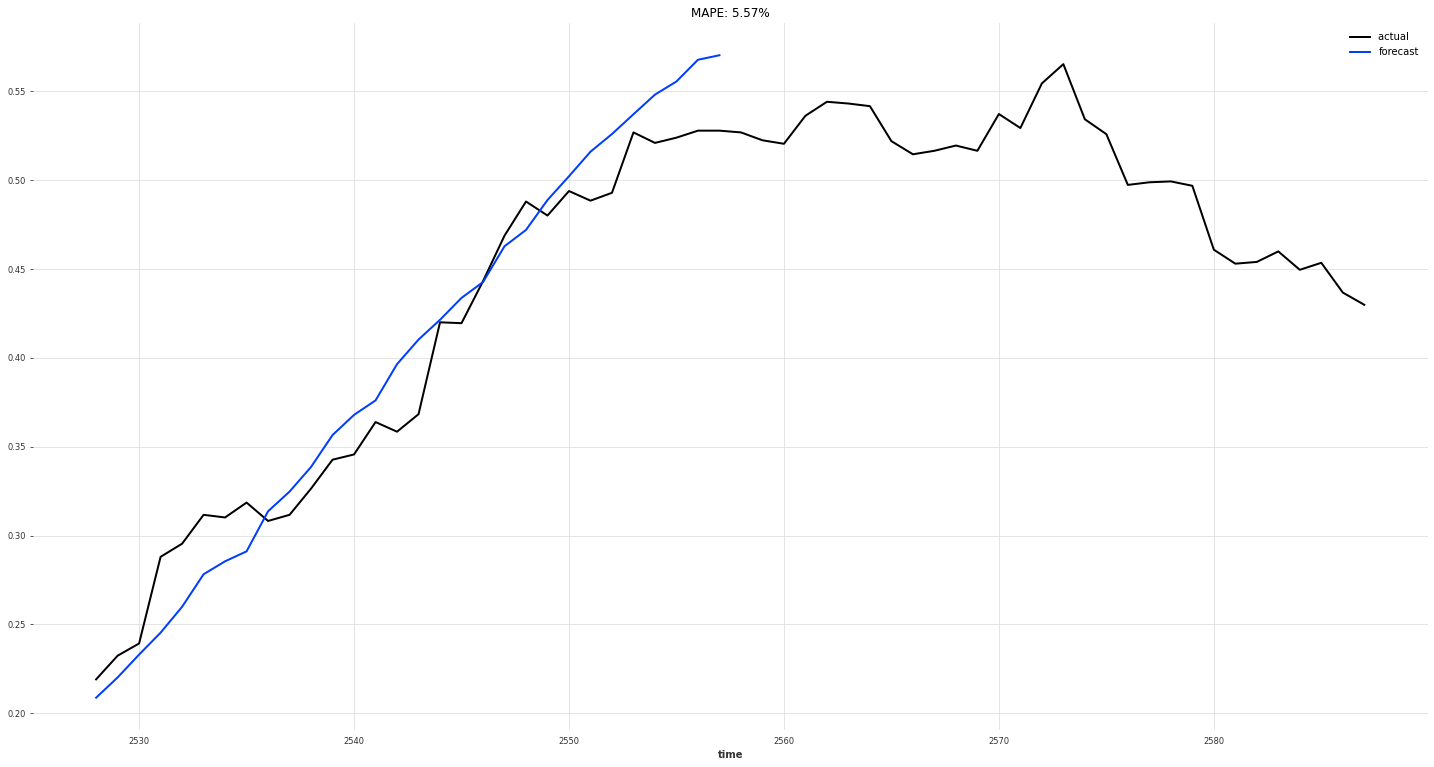

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('2_30min.png')


eval_model(my_model_, 30, val_scaled, val_scaled)

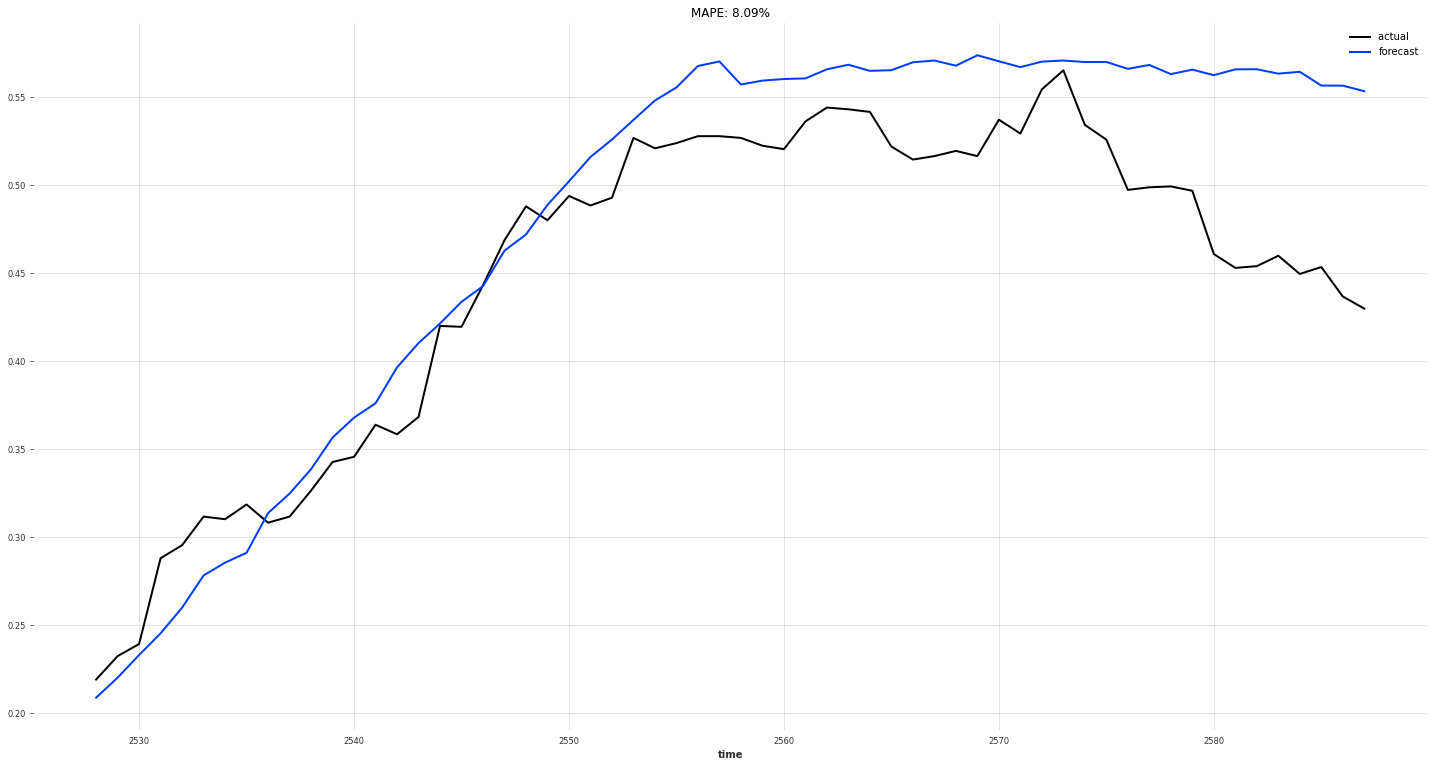

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('3_60min.png')


eval_model(my_model_, 60, val_scaled, val_scaled)

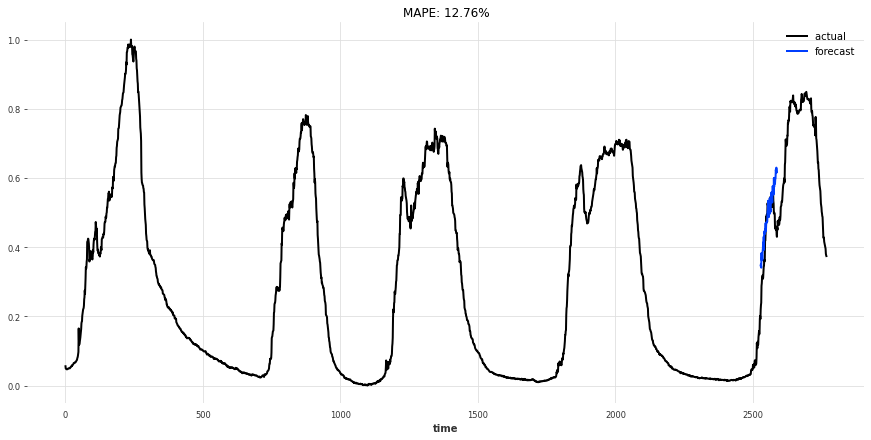

In [ ]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="transformer_training", best=True
)
eval_model(best_model, 60, ts_scaled, val_scaled)

In [ ]:
# this function is used to backtest the model at a forecasting horizon of three years (36 months)
def backtest(testing_model):
    # Compute the backtest predictions with the two models
    pred_series = testing_model.historical_forecasts(
        series=ts_scaled,
        start=pd.Timestamp("19401001"),
        forecast_horizon=36,
        stride=10,
        retrain=False,
        verbose=True,
    )

    pred_series_ets = ExponentialSmoothing().historical_forecasts(
        series=series_sp_scaled,
        start=pd.Timestamp("19401001"),
        forecast_horizon=36,
        stride=10,
        retrain=True,
        verbose=True,
    )
    val_sp_scaled.plot(label="actual")
    pred_series.plot(label="our Transformer")
    pred_series_ets.plot(label="ETS")
    plt.legend()
    print("Transformer MAPE:", mape(pred_series, val_sp_scaled))
    print("ETS MAPE:", mape(pred_series_ets, val_sp_scaled))


best_model_sp = TransformerModel.load_from_checkpoint(
    model_name="co2_transformer", best=True
)
backtest(best_model_sp)

# TCN model

In [ ]:
from darts.models import TCNModel

In [ ]:
model_tcn = TCNModel(
    input_chunk_length=180,
    output_chunk_length=30,
    n_epochs=500,
    dropout=0.2,
    weight_norm=True,
    dilation_base=2,
    kernel_size=5,
    num_layers=5, 
    num_filters=5, # so luong filter ben trong 1 lop conv cua TCN
    random_state=0,
)

In [ ]:
model_tcn.fit(
    series=train_scaled,
    val_series=val_scaled,
    verbose=True,
)

  0%|          | 1/500 [00:01<09:48,  1.18s/it]

  2%|▏         | 11/500 [00:13<09:38,  1.18s/it]

  4%|▍         | 21/500 [00:24<09:20,  1.17s/it]

  6%|▌         | 31/500 [00:36<09:15,  1.18s/it]

  8%|▊         | 41/500 [00:48<08:56,  1.17s/it]

 10%|█         | 51/500 [01:00<08:50,  1.18s/it]

 12%|█▏        | 61/500 [01:12<08:40,  1.19s/it]

 14%|█▍        | 71/500 [01:23<08:40,  1.21s/it]

 16%|█▌        | 81/500 [01:35<08:08,  1.17s/it]

 18%|█▊        | 91/500 [01:47<08:00,  1.17s/it]

 20%|██        | 101/500 [01:59<07:52,  1.19s/it]

 22%|██▏       | 111/500 [02:11<07:37,  1.18s/it]

 24%|██▍       | 121/500 [02:23<07:29,  1.19s/it]

 26%|██▌       | 131/500 [02:34<07:20,  1.19s/it]

 28%|██▊       | 141/500 [02:46<07:06,  1.19s/it]

 30%|███       | 151/500 [02:58<07:04,  1.22s/it]

 32%|███▏      | 161/500 [03:10<06:54,  1.22s/it]

 34%|███▍      | 171/500 [03:22<06:36,  1.21s/it]

 36%|███▌      | 181/500 [03:34<06:24,  1.20s/it]

 38%|███▊      | 191/500 [03:46<06:00,  1.17s/it]

 40%|████      | 201/500 [03:58<06:10,  1.24s/it]

 42%|████▏     | 211/500 [04:10<05:44,  1.19s/it]

 44%|████▍     | 221/500 [04:23<05:45,  1.24s/it]

 46%|████▌     | 231/500 [04:35<05:27,  1.22s/it]

 48%|████▊     | 241/500 [04:47<05:09,  1.19s/it]

 50%|█████     | 251/500 [04:59<05:01,  1.21s/it]

 52%|█████▏    | 261/500 [05:11<04:50,  1.22s/it]

 54%|█████▍    | 271/500 [05:23<04:34,  1.20s/it]

 56%|█████▌    | 281/500 [05:35<04:20,  1.19s/it]

 58%|█████▊    | 291/500 [05:47<04:02,  1.16s/it]

 60%|██████    | 301/500 [05:59<03:57,  1.19s/it]

 62%|██████▏   | 311/500 [06:11<03:48,  1.21s/it]

 64%|██████▍   | 321/500 [06:23<03:31,  1.18s/it]

 66%|██████▌   | 331/500 [06:34<03:14,  1.15s/it]

 68%|██████▊   | 341/500 [06:46<03:02,  1.15s/it]

 70%|███████   | 351/500 [06:58<02:55,  1.18s/it]

 72%|███████▏  | 361/500 [07:10<02:47,  1.20s/it]

 74%|███████▍  | 371/500 [07:22<02:34,  1.20s/it]

 76%|███████▌  | 381/500 [07:34<02:19,  1.18s/it]

 78%|███████▊  | 391/500 [07:46<02:07,  1.17s/it]

 80%|████████  | 401/500 [07:57<01:59,  1.20s/it]

 82%|████████▏ | 411/500 [08:10<01:48,  1.21s/it]

 84%|████████▍ | 421/500 [08:22<01:35,  1.21s/it]

 86%|████████▌ | 431/500 [08:34<01:21,  1.19s/it]

 88%|████████▊ | 441/500 [08:45<01:10,  1.19s/it]

 90%|█████████ | 451/500 [08:57<01:00,  1.22s/it]

 92%|█████████▏| 461/500 [09:09<00:45,  1.18s/it]

 94%|█████████▍| 471/500 [09:21<00:34,  1.21s/it]

 96%|█████████▌| 481/500 [09:33<00:22,  1.20s/it]

 98%|█████████▊| 491/500 [09:45<00:10,  1.17s/it]

100%|██████████| 500/500 [09:56<00:00,  1.19s/it]


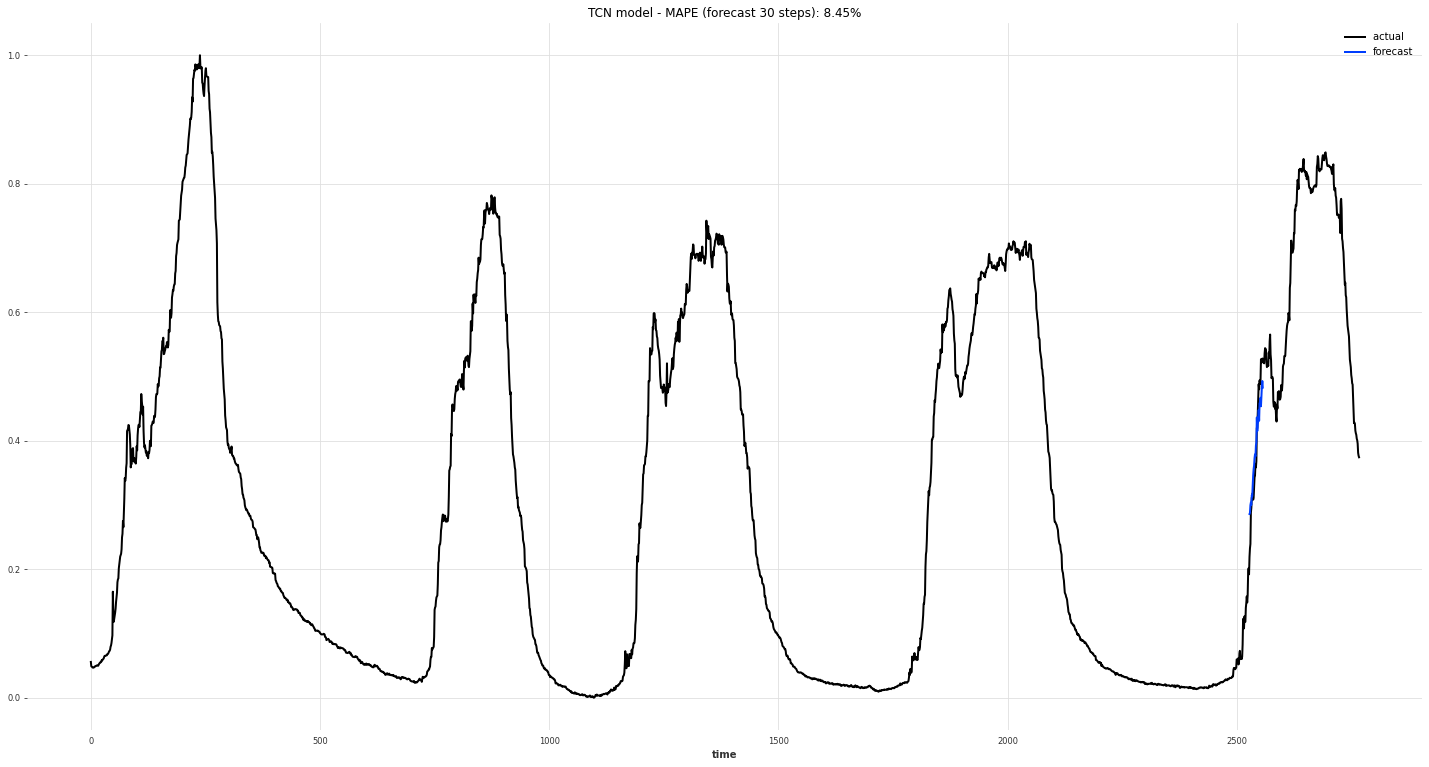

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model_tcn(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series.plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("TCN model - MAPE (forecast 30 steps): {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('tcn_1.png')


eval_model_tcn(model_tcn, 30, ts_scaled, val_scaled)

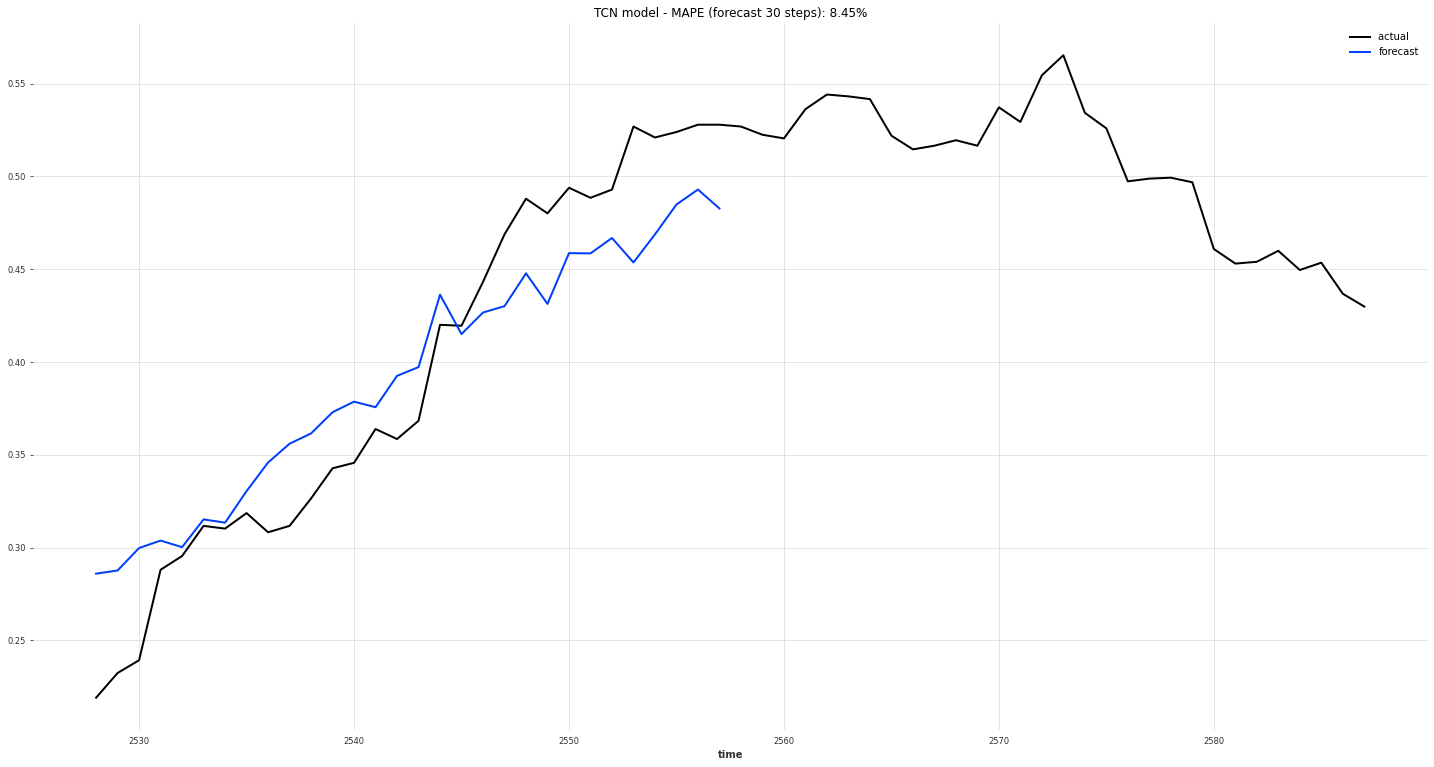

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model_tcn_2(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("TCN model - MAPE (forecast 30 steps): {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('tcn_2.png')


eval_model_tcn_2(model_tcn, 30, val_scaled, val_scaled)

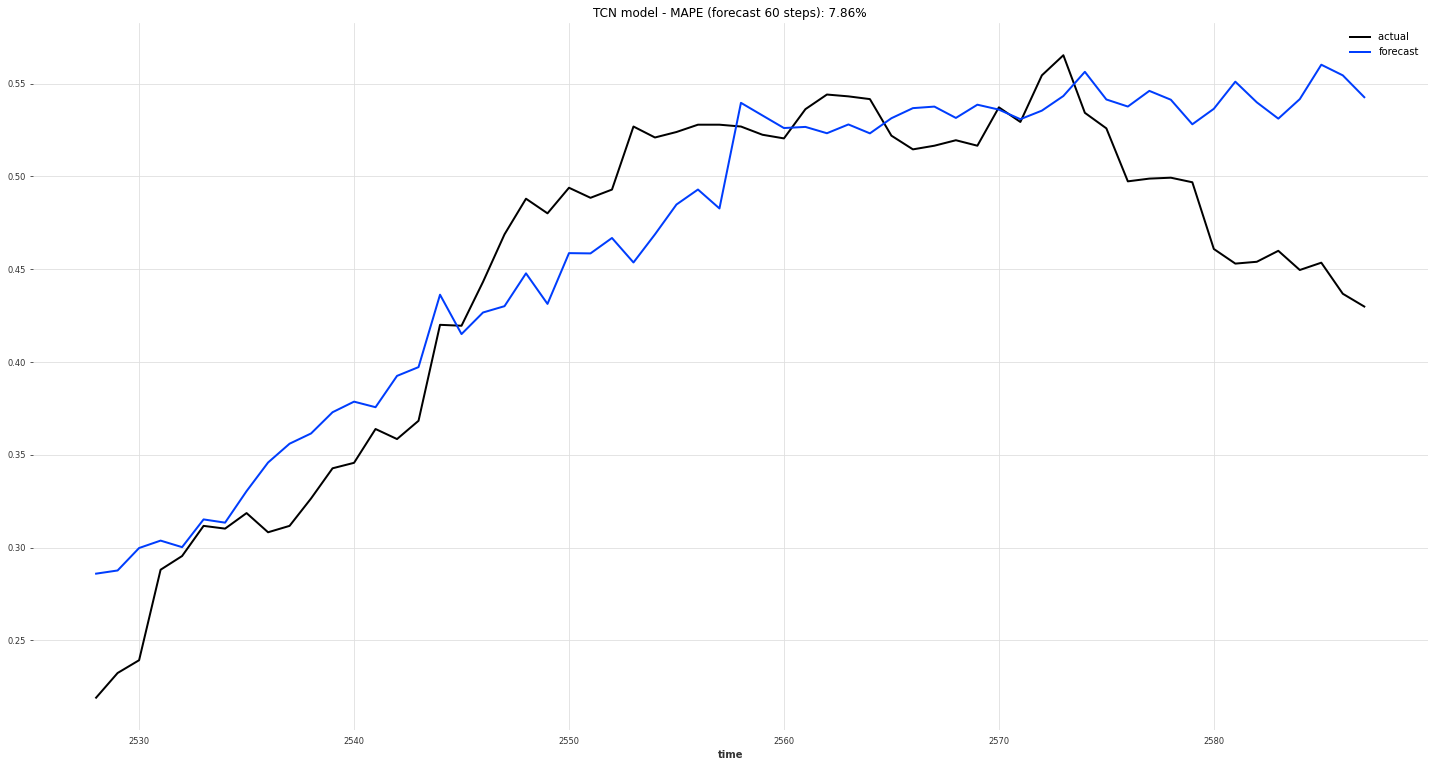

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model_tcn_3(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("TCN model - MAPE (forecast 60 steps): {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('tcn_2.png')


eval_model_tcn_3(model_tcn, 60, val_scaled, val_scaled)

In [ ]:
pred_series_test = model_tcn.predict(n=60)
pred_series_test

<TimeSeries (DataArray) (time: 60, component: 1, sample: 1)>
array([[[0.28592791]],

       [[0.28763684]],

       [[0.29974493]],

       [[0.30373344]],

       [[0.30020742]],

       [[0.31515049]],

       [[0.31340599]],

       [[0.33039072]],

       [[0.34580332]],

       [[0.35593561]],

...

       [[0.54127377]],

       [[0.52803942]],

       [[0.53638222]],

       [[0.55099606]],

       [[0.53985989]],

       [[0.53108263]],

       [[0.54161355]],

       [[0.560134  ]],

       [[0.55440189]],

       [[0.54263291]]])
Coordinates:
  * time       (time) int64 2528 2529 2530 2531 2532 ... 2584 2585 2586 2587
  * component  (component) object 'co2'
Dimensions without coordinates: sample

# TFT

In [35]:
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
model_tft = TFTModel(
    input_chunk_length=180,
    output_chunk_length=30,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.2,
    batch_size=16,
    n_epochs=150,
    add_relative_index=True,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
    loss_fn=torch.nn.MSELoss(),
    random_state=42,
)

In [36]:
model_tft.fit(series=train_scaled, val_series=val_scaled, verbose=True)


  1%|          | 1/150 [00:23<57:42, 23.24s/it]

  7%|▋         | 11/150 [04:13<53:16, 23.00s/it]

 14%|█▍        | 21/150 [08:03<49:30, 23.02s/it]

 21%|██        | 31/150 [11:54<45:48, 23.09s/it]

 27%|██▋       | 41/150 [15:45<41:59, 23.12s/it]

 34%|███▍      | 51/150 [19:36<38:09, 23.13s/it]

 41%|████      | 61/150 [23:26<34:11, 23.05s/it]

 47%|████▋     | 71/150 [27:16<30:13, 22.95s/it]

 54%|█████▍    | 81/150 [31:06<26:29, 23.04s/it]

 61%|██████    | 91/150 [34:56<22:34, 22.96s/it]

 67%|██████▋   | 101/150 [38:47<18:55, 23.18s/it]

 74%|███████▍  | 111/150 [42:38<15:02, 23.14s/it]

 81%|████████  | 121/150 [46:29<11:11, 23.15s/it]

 87%|████████▋ | 131/150 [50:19<07:15, 22.92s/it]

 94%|█████████▍| 141/150 [54:08<03:26, 22.97s/it]

100%|██████████| 150/150 [57:36<00:00, 23.04s/it]


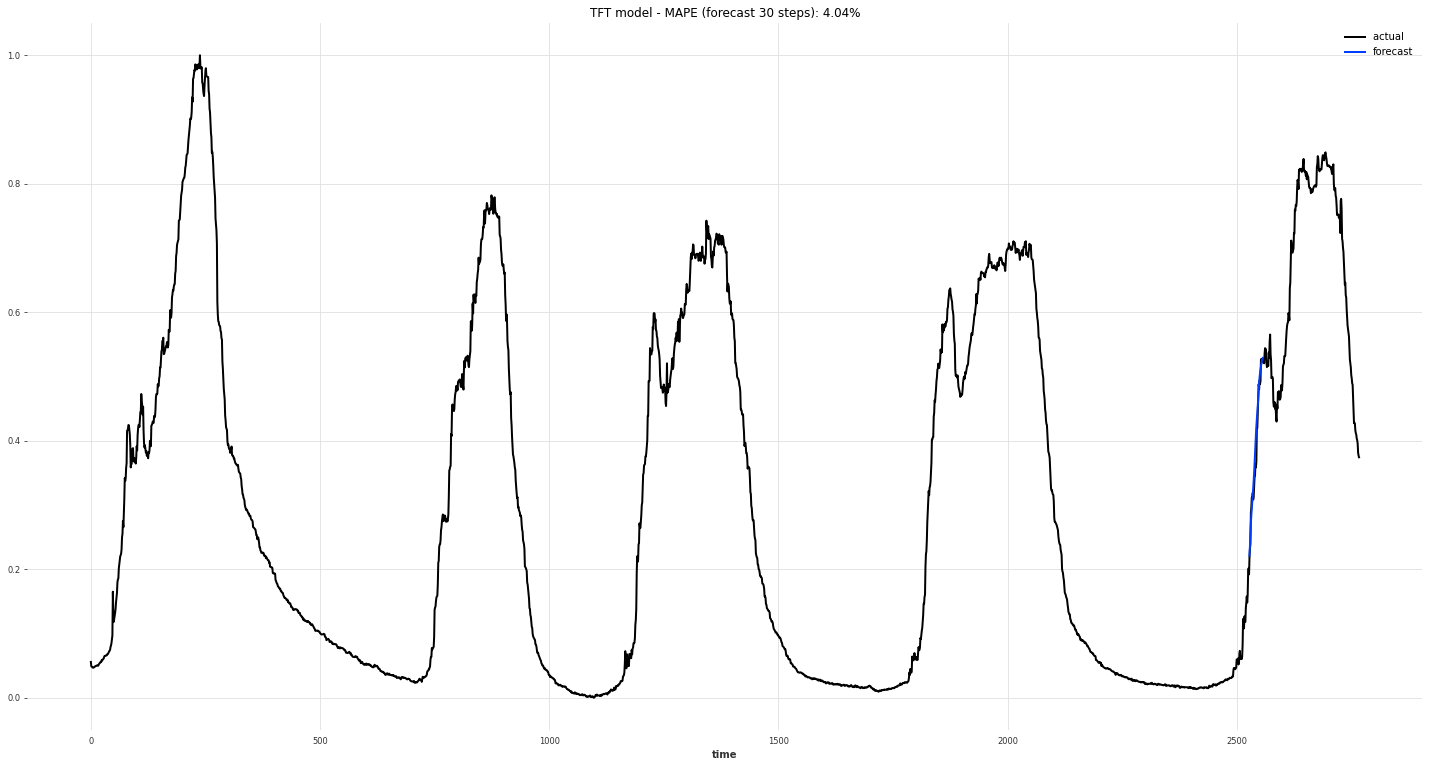

In [42]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model_tft(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series.plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("TFT model - MAPE (forecast 30 steps): {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('tft_1.png')


eval_model_tft(model_tft, 30, ts_scaled, val_scaled)

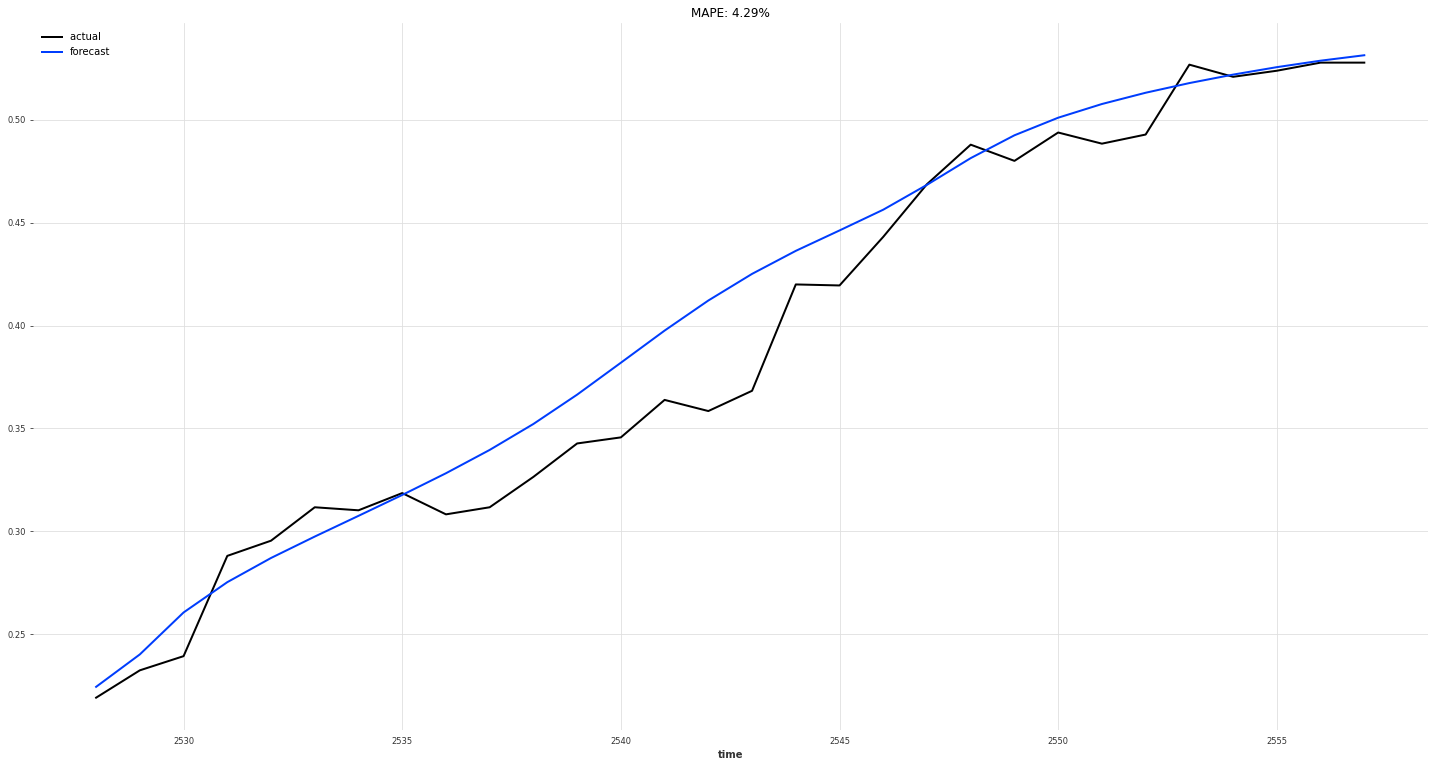

In [49]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model_tft_2(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:30].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('tft_2_30min.png')


eval_model_tft_2(model_tft, 30, val_scaled, val_scaled)

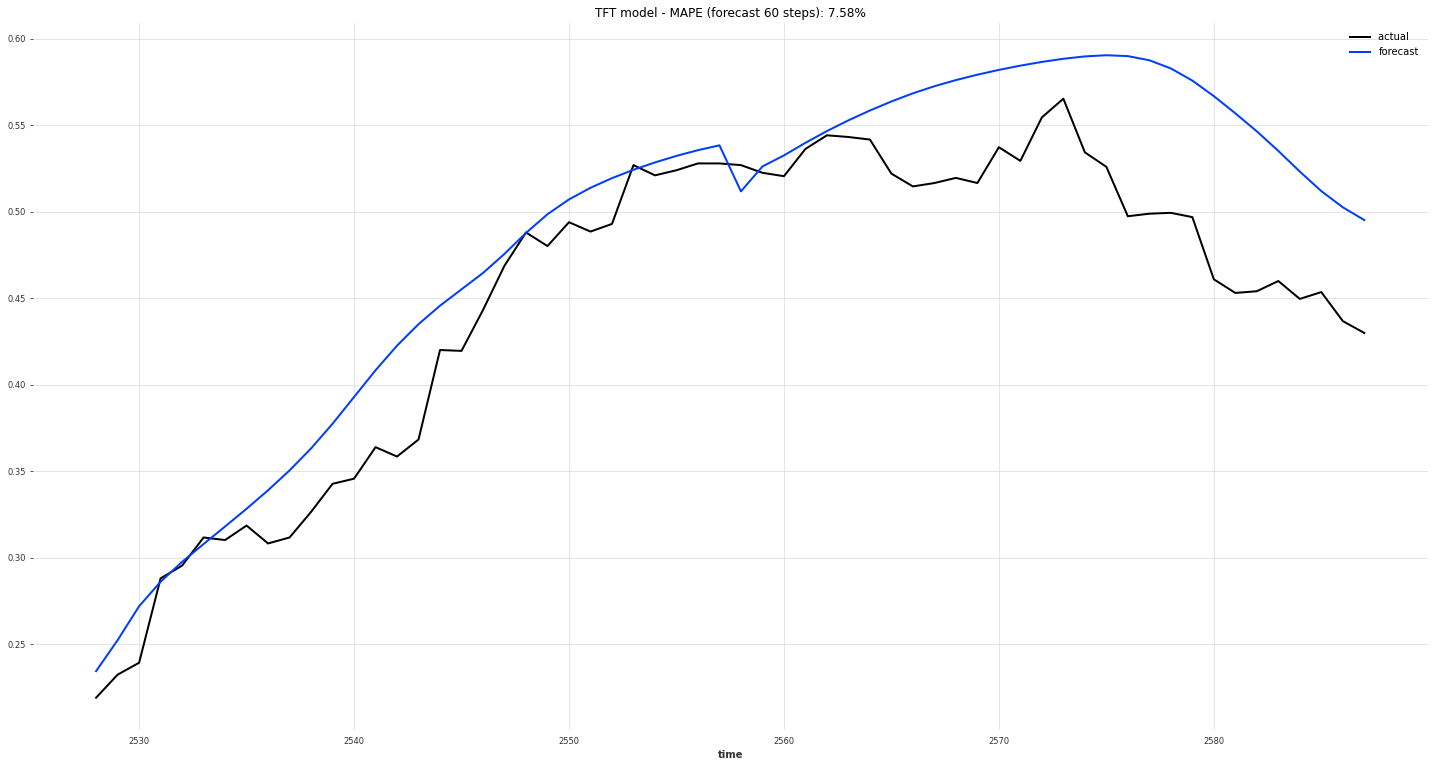

In [57]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model_tft_3(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("TFT model - MAPE (forecast 60 steps): {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('tcn_3_60_min.png')


eval_model_tft_3(model_tft, 60, val_scaled, val_scaled)